In [958]:
import pprint
import pickle
import operator
import helpers
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from data import data_keys
from functools import reduce
from ast import literal_eval
from geopy import geocoders
from dython.nominal import associations
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.constrained_layout.use'] = True

In [959]:
# runtime parameters to save time when rerunning

save_pairplot = False

# Introduction

In this notebook, I explore the Airbnb dataset for its listings in Amsterdam, The Netherlands. 
I chose this challenge because of its relatively large dataset with about 100 columns of numerical, categorical, geological, image, and text data.
(Dataset originally from http://insideairbnb.com/get-the-data.html) Since the dataset has no data keys, so I would try my best to explain them. 
 
For this challenge, we would try to predict prices based on other variables.

# Hypothesis

I hypothesize is that I could achieve an R-squared value of around .6 through the most useful 20 features or so.
Some variables that would probably be of most use 
are all of the "primary_num_cols" in data keys, "instant_bookable", "host_has_profile_pic", "host_identity_verified", 
"neighbourhood_cleansed", "cancellation_policy", "description", "neighborhood_overview", "transit", "house_rules", 
pictures of the listings as well as host profile pictures, and in fact, the past availability (although we could not use this one since we mostly only have aggregated availability statistics).


# Exploratory Data Analysis
First, we load the dataset and classify the columns into different types and access their useability.

In [960]:
df = pd.read_csv("../data/listings.csv", converters={"host_verifications": literal_eval})
print("Shape: ", df.shape)
df.describe()

Shape:  (20677, 106)


,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.067700e+04,2.067700e+04,0.0,0.0,0.0,2.067700e+04,0.0,20665.000000,20665.000000,0.0,20677.000000,20677.000000,20677.000000,20671.000000,20669.000000,20669.000000,386.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,20677.000000,17861.00000,17850.000000,17852.000000,17840.000000,17847.000000,17842.000000,17842.000000,20677.000000,20677.000000,20677.000000,20677.000000,18084.000000
mean,1.791013e+07,2.019081e+13,NaN,NaN,NaN,5.666981e+07,NaN,7.010888,7.010888,NaN,52.365278,4.889565,2.879335,1.158580,1.454400,1.829213,548.435233,1.459351,3.546694,617.663297,3.516371,3.838129,602.894472,611.190937,3.653485,606.781022,3.783479,7.686173,12.423321,54.104609,23.290323,6.998597,94.97962,9.687283,9.469079,9.735762,9.789488,9.476124,9.177054,4.925134,4.492431,0.410988,0.021715,0.987736
std,1.041987e+07,7.800970e+00,NaN,NaN,NaN,6.812902e+07,NaN,37.729548,37.729548,NaN,0.016353,0.035970,1.314935,0.380091,0.894856,1.407580,555.655913,0.935662,18.690394,537.978553,18.688704,18.874855,538.915327,537.842556,18.759495,536.703416,7.219078,14.491902,22.936166,99.488601,48.619730,14.239550,6.63050,0.693180,0.867372,0.654358,0.610074,0.707655,0.808275,22.883678,22.710906,1.082794,0.237805,1.349155
min,2.818000e+03,2.019081e+13,NaN,NaN,NaN,3.159000e+03,NaN,0.000000,0.000000,NaN,52.289270,4.753120,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,9.340207e+06,2.019081e+13,NaN,NaN,NaN,8.795077e+06,NaN,1.000000,1.000000,NaN,52.355130,4.863870,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,21.000000,2.000000,2.000000,20.000000,21.000000,2.000000,21.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,93.00000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.240000
50%,1.774427e+07,2.019081e+13,NaN,NaN,NaN,2.618942e+07,NaN,1.000000,1.000000,NaN,52.364620,4.887030,2.000000,1.000000,1.000000,1.000000,484.000000,1.000000,2.000000,1125.000000,2.000000,3.000000,1124.000000,1124.000000,2.300000,1124.000000,0.000000,0.000000,0.000000,1.000000,9.000000,2.000000,97.00000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.540000
75%,2.601974e+07,2.019081e+13,NaN,NaN,NaN,7.754037e+07,NaN,2.000000,2.000000,NaN,52.375190,4.909260,4.000000,1.000000,2.000000,2.000000,861.000000,2.000000,3.000000,1125.000000,3.000000,4.000000,1125.000000,1125.000000,3.000000,1125.000000,4.000000,8.000000,13.000000,50.000000,23.000000,7.000000,100.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,1.070000
max,3.759099e+07,2.019081e+13,NaN,NaN,NaN,2.839422e+08,NaN,980.000000,980.000000,NaN,52.424710,5.027690,30.000000,15.000000,12.000000,32.000000,3229.000000,16.000000,1001.000000,1825.000000,1001.00

As we can see the data are of mixed types and have missing records. I proceeded to inspect the variables one by one.
The result is [our own data keys](../data/data_keys.py). Most classification is a process of examination 
the type of data, unique values, and readiness of feeding into machine learning training models (level of tidiness).
 

## Data cleaning

Now, we include the dependent variable in our dataset to clean it along with other currency-based variables. 

In [961]:
num_attribs = data_keys.primary_num_cols + ["price"]
cat_attribs = data_keys.binary_cols + data_keys.cat_cols

We examine the percentage of missing data for each variable.

In [962]:
nan_ptc_dict = {}
for price_col in list(df[num_attribs + cat_attribs]):
    count_nan = len(df[price_col]) - df[price_col].count()
    if (count_nan):
        nan_ptc_dict[f"nan percentage for {price_col}"] = count_nan / len(df)

sorted_d = sorted(nan_ptc_dict.items(), key=operator.itemgetter(1), reverse=True)
pprint.pprint(sorted_d)

[('nan percentage for square_feet', 0.9813319146878173),
 ('nan percentage for host_response_rate', 0.4130676597185278),
 ('nan percentage for host_response_time', 0.4130676597185278),
 ('nan percentage for security_deposit', 0.29994680079315184),
 ('nan percentage for host_neighbourhood', 0.28713062823426994),
 ('nan percentage for cleaning_fee', 0.17995840789282777),
 ('nan percentage for review_scores_checkin', 0.1372055907530106),
 ('nan percentage for review_scores_location', 0.13710886492237753),
 ('nan percentage for review_scores_value', 0.13710886492237753),
 ('nan percentage for review_scores_communication', 0.13686705034579486),
 ('nan percentage for review_scores_accuracy', 0.13672196159984523),
 ('nan percentage for review_scores_cleanliness', 0.13662523576921218),
 ('nan percentage for review_scores_rating', 0.13618996953136336),
 ('nan percentage for zipcode', 0.04284954297045026),
 ('nan percentage for state', 0.010591478454321226),
 ('nan percentage for market', 0.0019

Most variables are relatively complete. 
Some other variables such as host response rate have high levels of incompleteness (about 40%), 
so we would impute these variables for missing records.
Since the square_feet variable is missing for over 98% of the data, it barely provides any useful information and renders imputation itself worthless. We would drop it.

In [963]:
df, num_attribs = helpers.drop_attribs(df, num_attribs, ['square_feet'])

## Numerical Variable
Then, we properly convert string-based variables to pure numbers.

In [964]:
df["host_response_rate"] = df["host_response_rate"].apply(lambda x: helpers.percent_to_float(x))

for col in ["price", "security_deposit", "cleaning_fee", "extra_people"]:
    df[col] = df[col].apply(lambda x: helpers.convert_string_to_dollar(str(x)))

# Clearly some variables naturally should be positive (non-zero)
df = df[(df["price"] > 0) &
        (df["accommodates"] > 0)]

### Visualizations

In [965]:
# construct a dunny variable for display since plotly doesn't support onclick events well
df["name_and_listing_url"] = df[['name', 'listing_url']].astype(str).apply('\n'.join, axis=1)

# an example token plotly has generously provided
px.set_mapbox_access_token('pk.eyJ1IjoiZXRwaW5hcmQiLCJhIjoiY2luMHIzdHE0MGFxNXVubTRxczZ2YmUxaCJ9.hwWZful0U2CQxit4ItNsiQ')
# df = px.data.carshare()
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="price", size="price", hover_name="name_and_listing_url",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=13, title="Airbnb Netherlands Listings") 
fig.show()

We can see that the majority of the listings are below 200 dollars, and the expensive listings are almost all in the central area in Amsterdam.

Due to the large number of variables, I chose to save the extremely large pairplot as a separate file [here](../imgs/pairplot.png).
Note: if you want to save the image, please uncomment the line below or the value of the save_pairplot at the beginning

In [966]:
# uncomment below to save images
# save_pairplot = True

if save_pairplot:
    sns.pairplot(df[num_attribs]).savefig("../imgs/pairplot.png")
    plt.suptitle("Initial Pairlot")
    plt.close() # too many variables for inline plots

### Feature Transformation

By examining the pairplot, we can see that many variables are right-skewed. 

Let's try log transformation.

In [967]:
to_log_transform = ["price", "security_deposit", "cleaning_fee", "extra_people",
            "bathrooms", "bedrooms", "beds", "guests_included",
            "number_of_reviews"]
new_col_names = []

for col in to_log_transform:
    new_col_name = f"log_{col}"
    new_col_names.append(new_col_name)
    df[new_col_name] = np.log(df[col] + 1)
    num_attribs.append(new_col_name)

df, num_attribs = helpers.drop_attribs(df, num_attribs, to_log_transform)

Text(0.5, 0.98, 'Histogram of Transformed Variables')

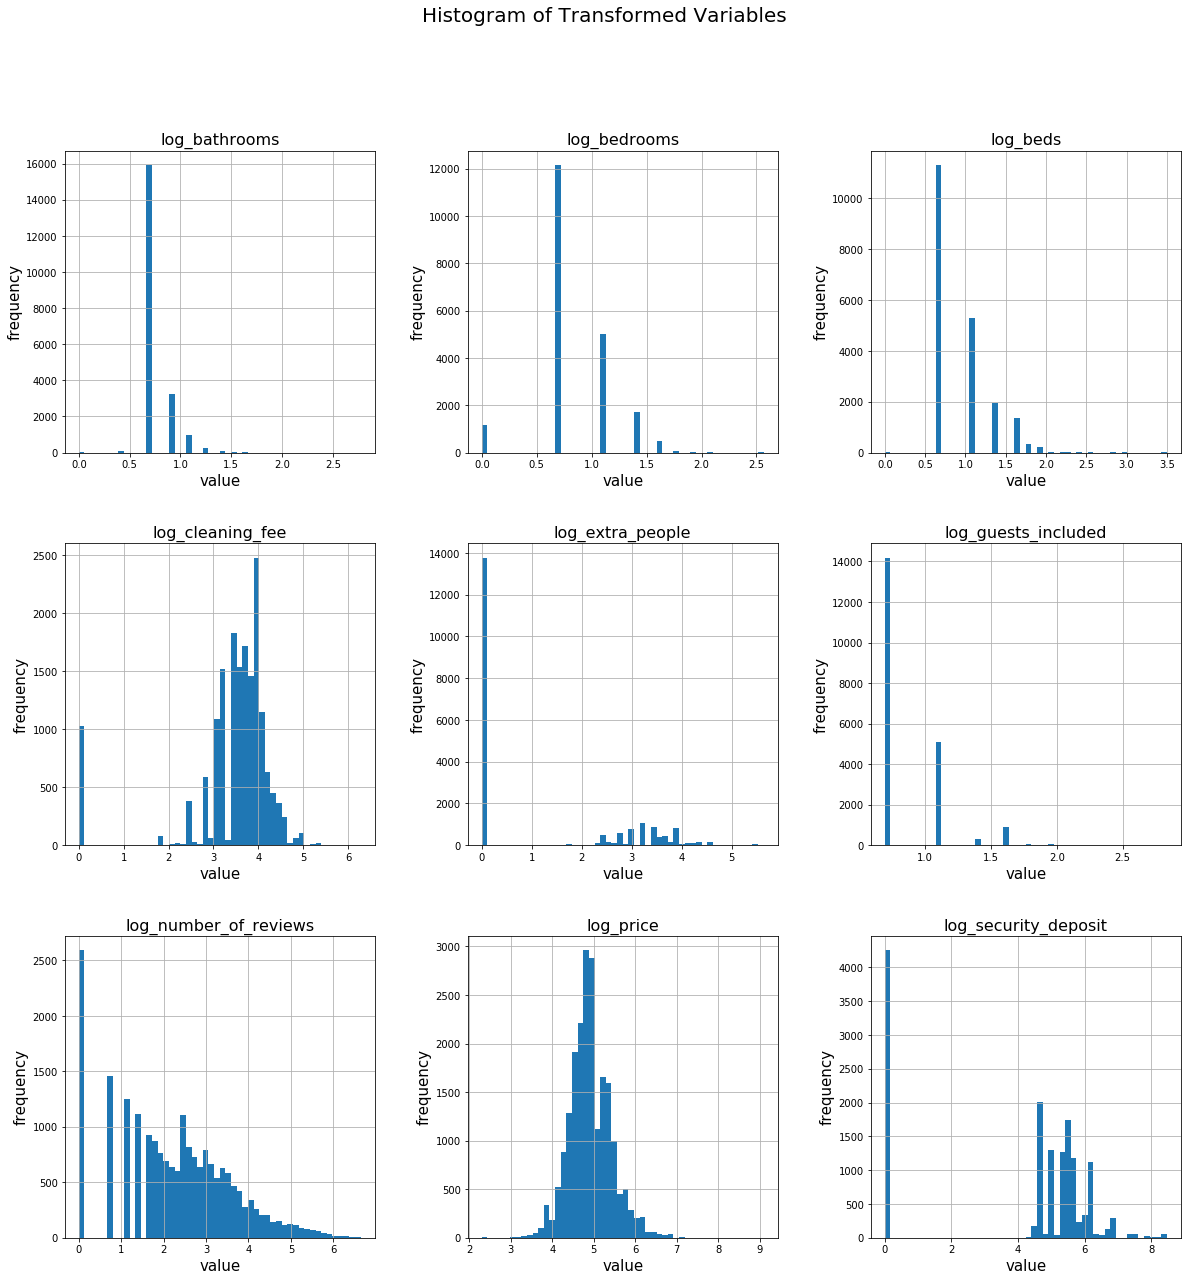

In [968]:
## check the transformed variables

axarr = df[new_col_names].hist(bins=50, figsize=(20, 20))
for ax in axarr.flatten():
    ax.set_xlabel("value")
    ax.set_ylabel("frequency")
    
plt.suptitle("Histogram of Transformed Variables")

Most of the variables are much less skewed and normal. The plots here also make sense since most fees/prices tend to be log-normal distributed. We can rationalize it by thinking that most customers are interested in cheap listings while high-end listings mostly cater to a small portion fo the market. 
A similar rationale applies to the other variables that are right-skewed.
For some variables such as beds, a second log transformation might help. Here we would just keep our model simple in performing only one log transformation.

### Feature Engineering

Some variables could be combined to form more meaningful variables. 
One typical example in housing datasets is rooms per accommodates. 

In [969]:
base_col = "accommodates"

for col in ["log_bedrooms", "log_bathrooms"]:
    new_col_name = f"{col}_per_{base_col}"
    df[new_col_name] = df[col] / df[base_col]
    num_attribs.append(new_col_name)

### Feature Elimination

We can also examine the correlation heatmap, which would serve as guidance for further data elimination.

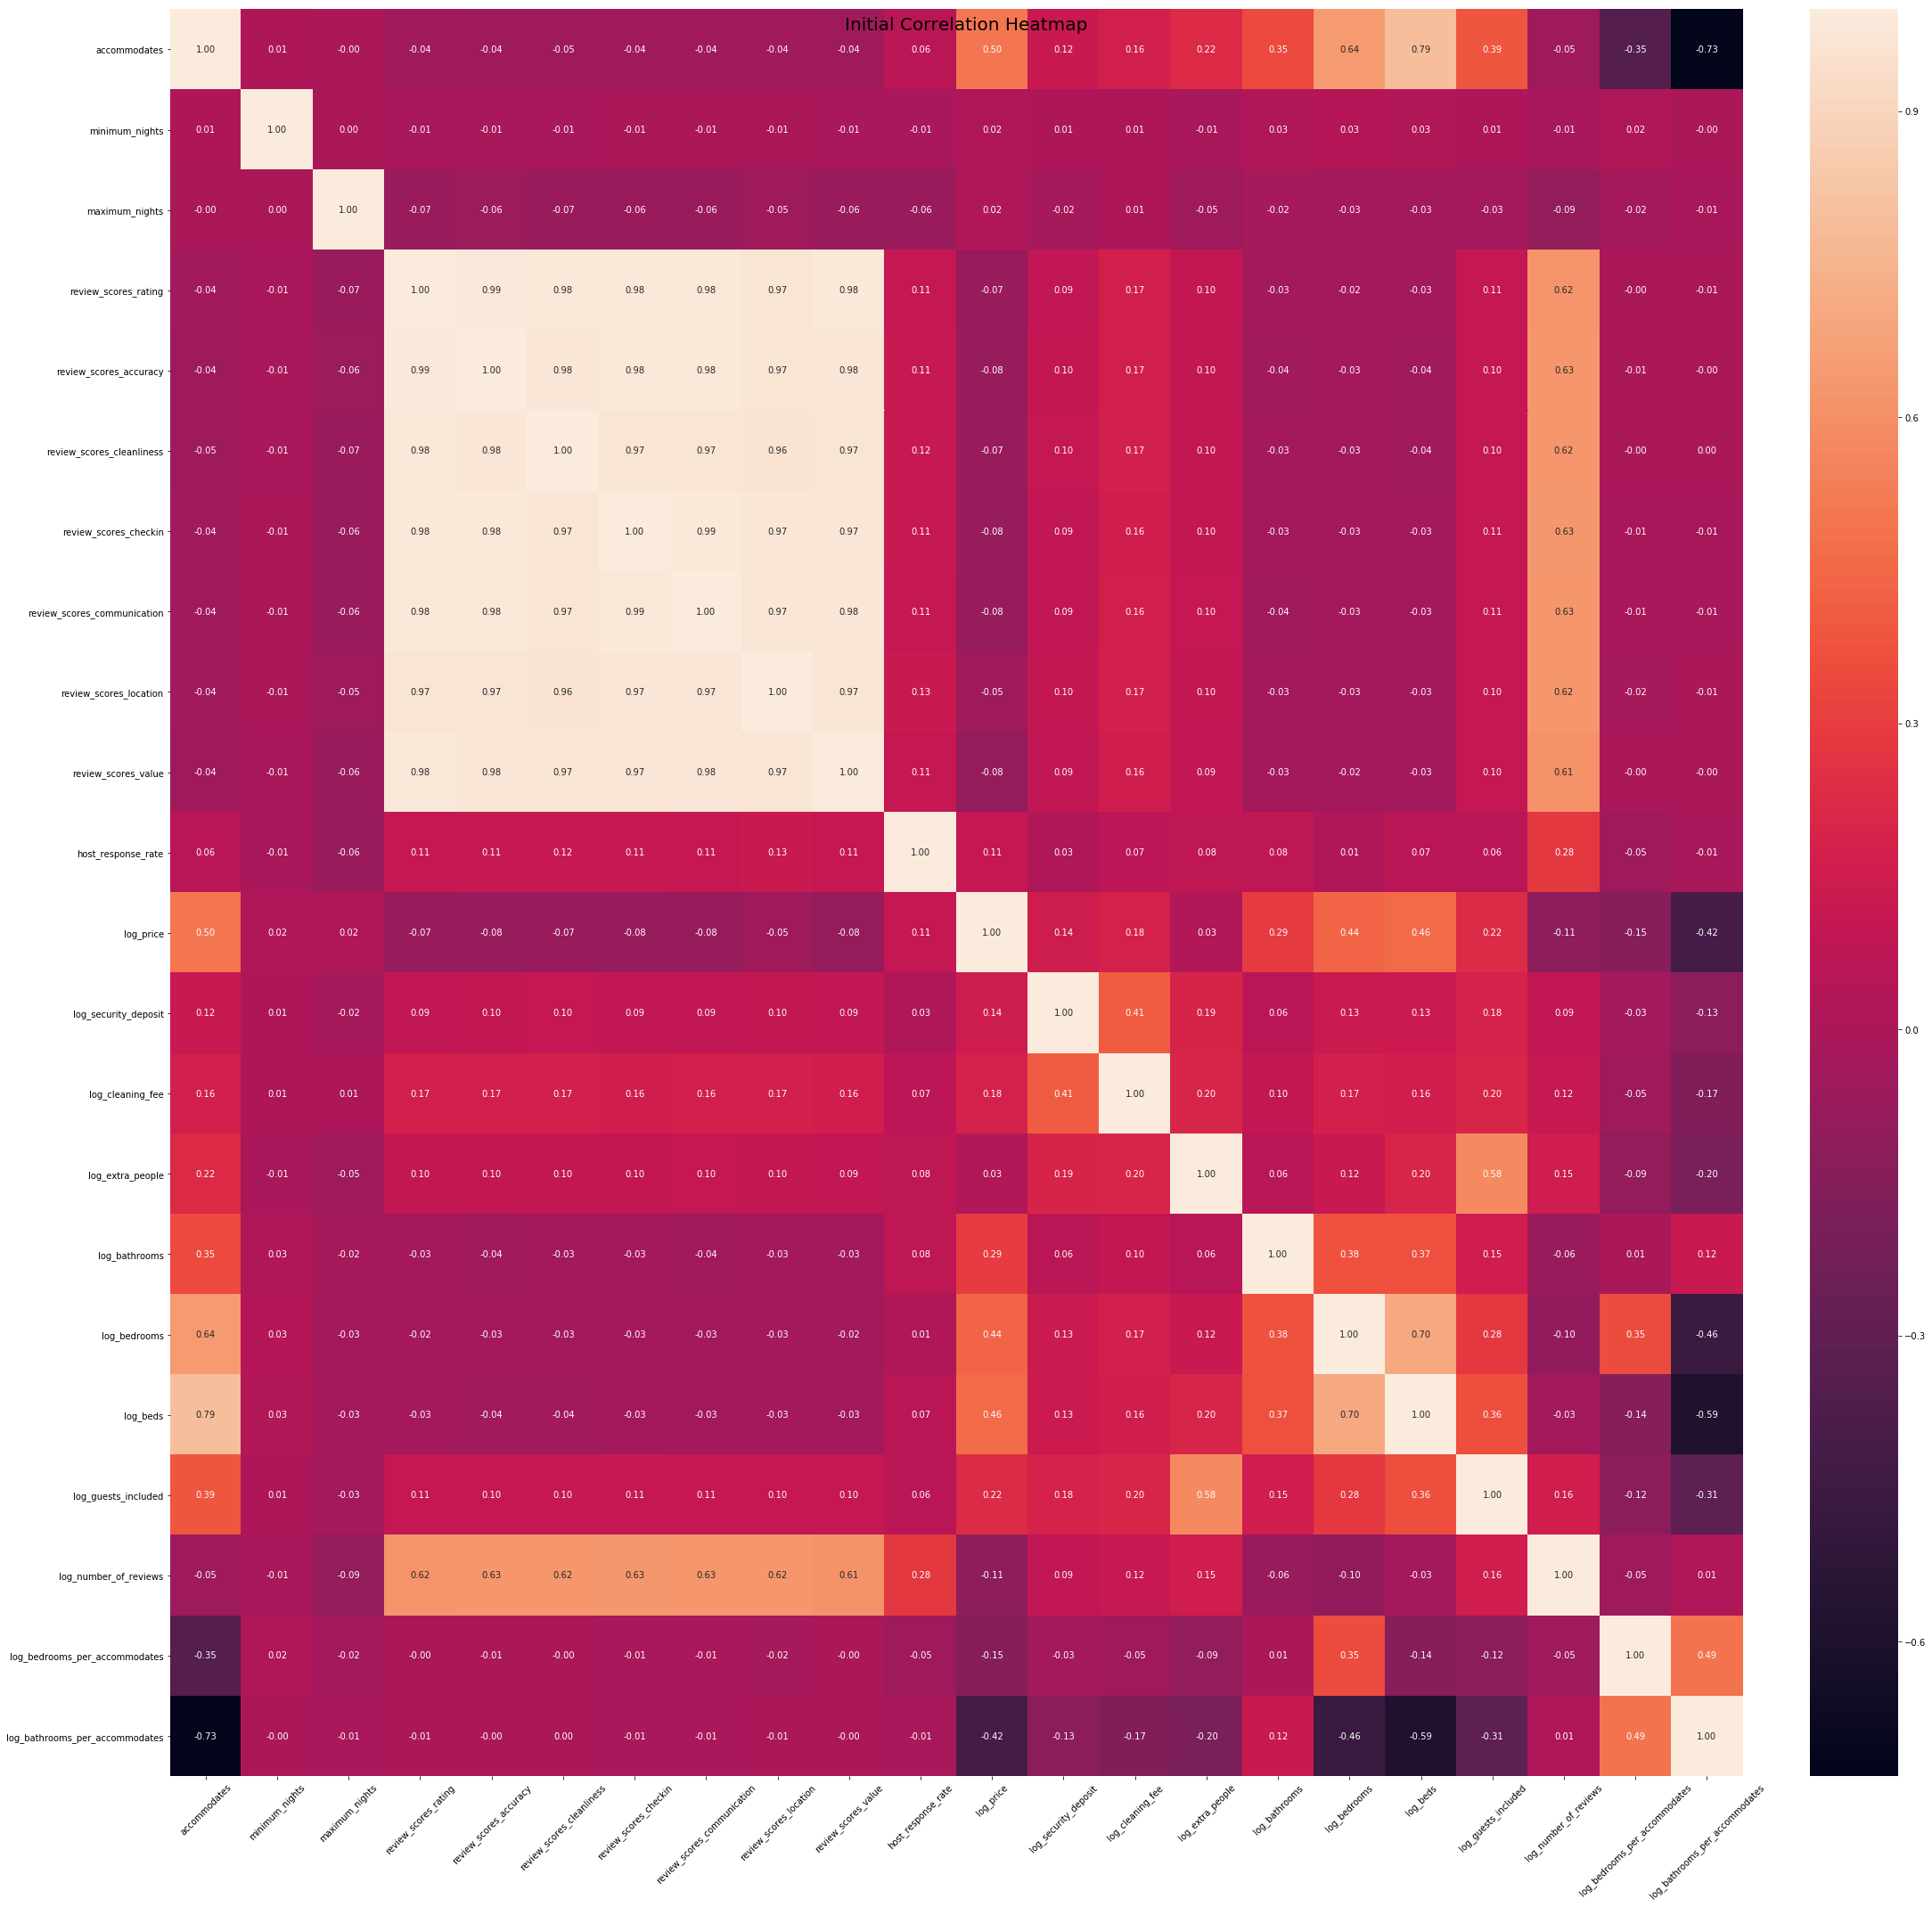

In [970]:
fig, ax = plt.subplots(figsize=(30, 30))
associations(df[num_attribs], theil_u=True, ax=ax)
plt.xticks(rotation=45)
plt.suptitle("Initial Correlation Heatmap")
plt.savefig("../imgs/correlation_heatmap_before.png")

Check the saved correlation heatmap [here](../imgs/correlation_heatmap_before.png).

We now proceed to examine the highly correlated ones.

Text(0.5, 0.98, 'Correlation Heatmap for Review-based Variables')

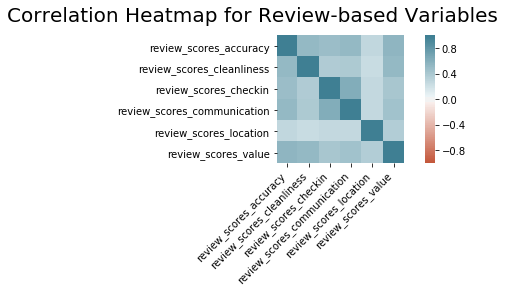

In [971]:
review_col_names = ['review_scores_accuracy', 'review_scores_cleanliness', \
                   'review_scores_checkin', 'review_scores_communication', \
                   'review_scores_location', 'review_scores_value']

helpers.corr_heatmap(df[review_col_names].corr())
plt.suptitle("Correlation Heatmap for Review-based Variables")

Actually, there are not too strong correlations between the different types of reviews, except "review_scores_location." 
Let's just use review_scores_rating since we have many variables with the exact locations.

In [972]:
df['avg_review'] = df[review_col_names].mean(axis=1)

df[['review_scores_rating', "avg_review"] + review_col_names].corr()

,review_scores_rating,avg_review,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
review_scores_rating,1.000000,0.813368,0.683038,0.660347,0.541946,0.597463,0.342277,0.662979
avg_review,0.813368,1.000000,0.780069,0.740820,0.714878,0.729915,0.560879,0.785463
review_scores_accuracy,0.683038,0.780069,1.000000,0.530813,0.484389,0.528306,0.288246,0.548149
review_scores_cleanliness,0.660347,0.740820,0.530813,1.000000,0.374927,0.395964,0.242589,0.522499
review_scores_checkin,0.541946,0.714878,0.484389,0.374927,1.000000,0.618134,0.277944,0.429079
review_scores_communication,0.597463,0.729915,0.528306,0.395964,0.618134,1.000000,0.266880,0.457579
review_scores_location,0.342277,0.560879,0.288246,0.242589,0.277944,0.266880,1.000000,0.360936
review_scores_value,0.662979,0.785463,0.548149,0.522499,0.429079,0.457579,0.360936,1.000000


In [973]:
review_col_to_drop = review_col_names + ["avg_review"]
df, num_attribs = helpers.drop_attribs(df, num_attribs, review_col_to_drop)

Delete less useful variables that the correlation heatmap shows as highly correlated.

In [974]:
df, num_attribs = helpers.drop_attribs(df, num_attribs, ["minimum_nights", "maximum_nights"])

First, there are four types of availability data (defined as the number of available days out of the number of days after the underscore). 

Text(0.5, 0.98, 'Histogram for Availability-based Variables')

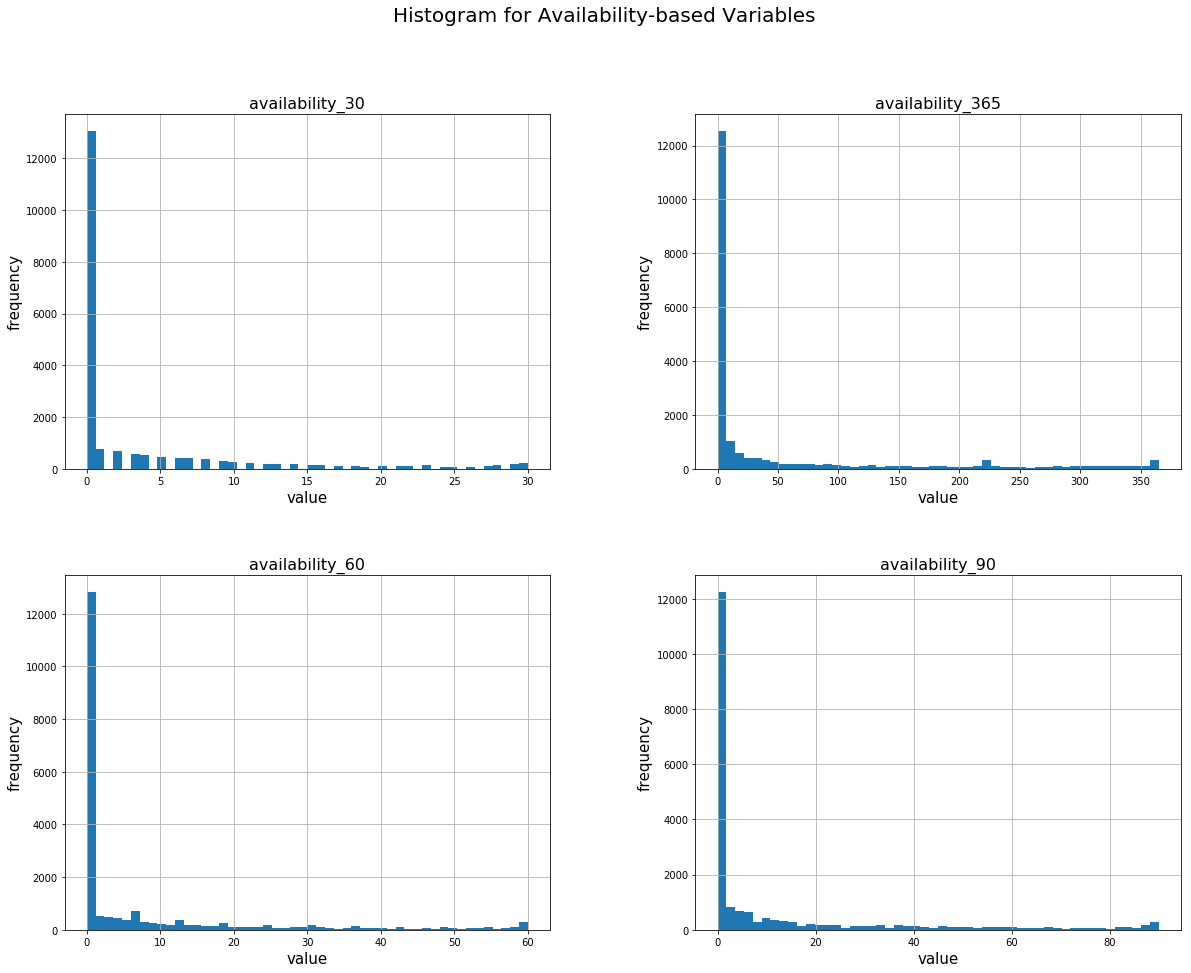

In [975]:
all_availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
axarr = df[all_availability_cols].hist(bins=50, figsize=(20,15))
for ax in axarr.flatten():
    ax.set_xlabel("value")
    ax.set_ylabel("frequency")
    
plt.suptitle("Histogram for Availability-based Variables")

The distribution of availability is extremely right-skewed and has very wide (uniform after 0) spread.
It makes sense since we would expect that hosts would strive to keep their listings occupied, resulting in low availability.
Thus, we could bin the variable into some intervals.

Let's use the availability for 365 days to eliminate short-term fluctuations that we don't care about.

In [976]:
all_availability_cols.remove('availability_365')
df.drop(all_availability_cols, axis=1, inplace=True)

Now we would only keep the variables that we have hypothesized to be of great importance.

In [977]:
df = df[num_attribs + cat_attribs]
df.shape

(20676, 35)

We have a bit fewer variables to work with.
Let's inspect the pairplot again.

In [978]:
if save_pairplot:
    sns.pairplot(df).savefig("../imgs/transformed_pairplot.png")
    plt.close() # too many variables for inline plots

Check the saved transformed pairplot [here](../imgs/transformed_pairplot.png).
The pairplot looks great as log_price has high correlations with the other variables.

## Categorical Variables

In [979]:
# the "host_verificaton" varible is a list of verification methods that is hard to compare and draw a bar plot with.
cat_attribs_to_plot = [i for i in cat_attribs if i != "host_verifications"]

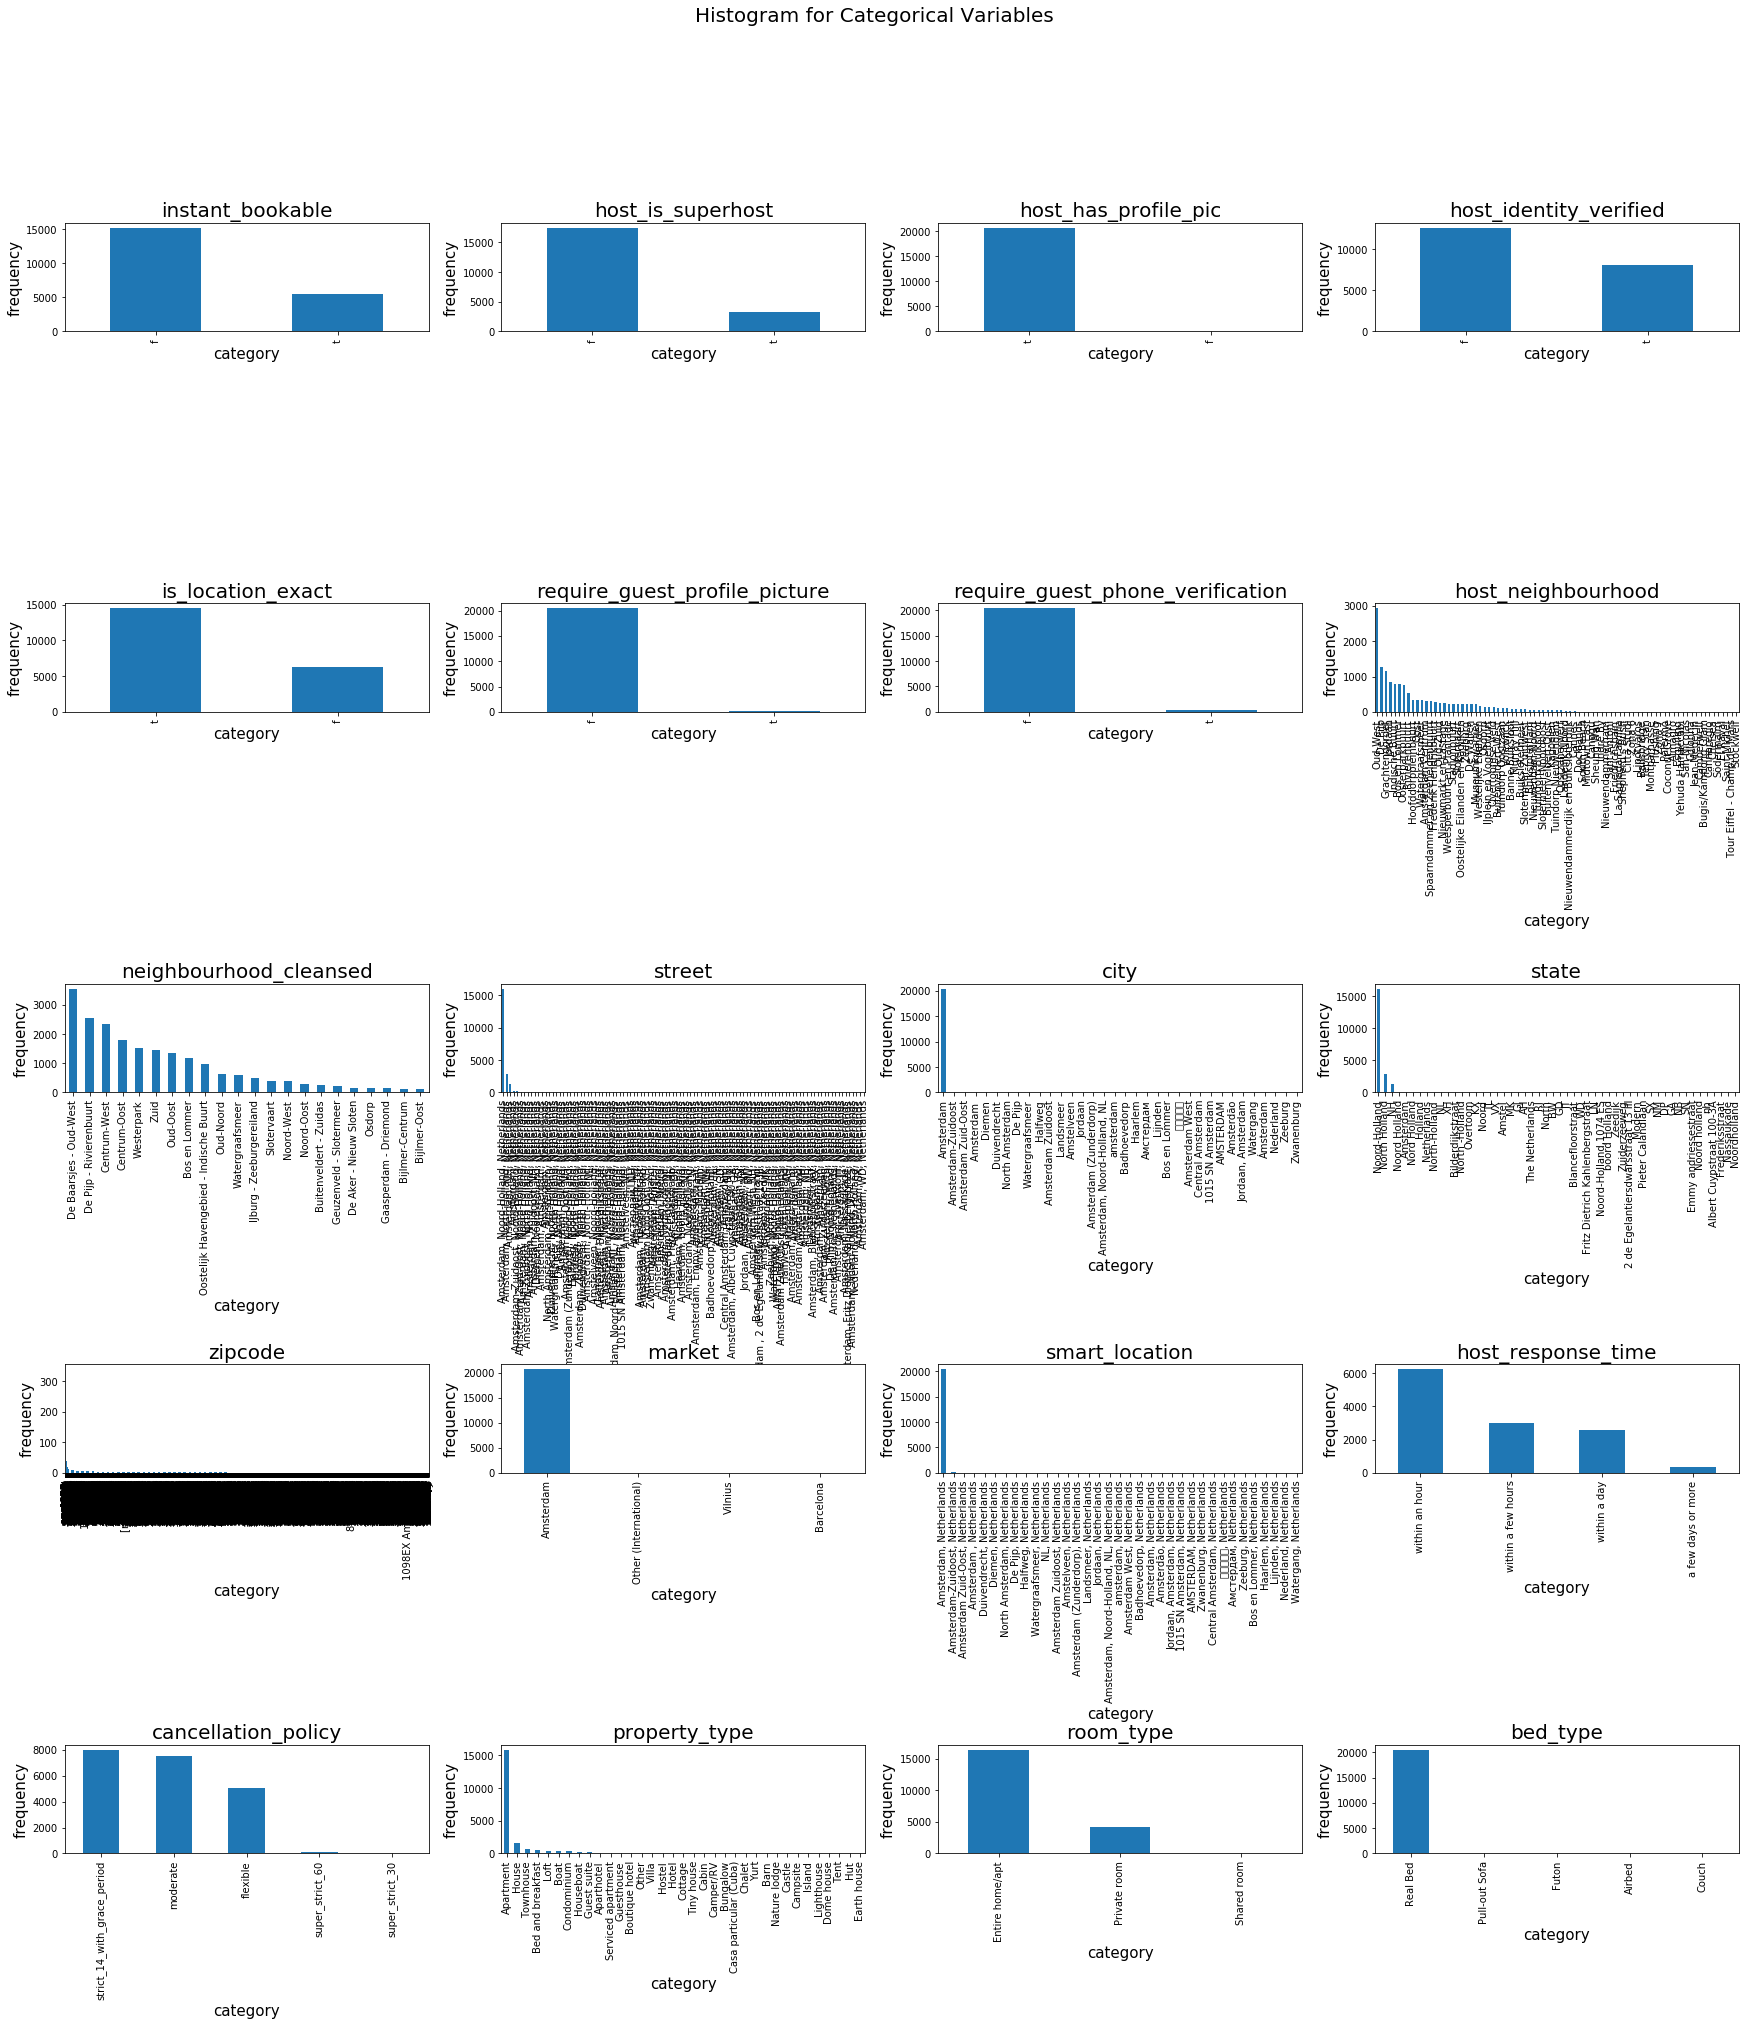

In [980]:
# len(cat_attribs_to_plot) is 20, so let's make the plot 5 * 4
fig, ax = plt.subplots(5, 4, figsize=(30, 30))
fig.subplots_adjust(hspace=2.5)
i = 0
j = 0
for _, categorical_feature in enumerate(df[cat_attribs_to_plot]):
    counts = df[categorical_feature].value_counts()
    res = counts.plot("bar", ax=ax[i, j])
    res.set_title(categorical_feature)
    res.set_xlabel("category")
    res.set_ylabel("frequency")
    res.title.set_size(20)
    if j == 3:
        j = 0
        i += 1
    else:
        j += 1
plt.suptitle("Histogram for Categorical Variables")
fig.show()

We can see that most variables have several types of categories. Some spatial variables have a great amount of categories. For the performance of the model, we would reduce it to a simpler variable later. Meanwhile, we would construct a verification variable that encapsulates the information from variables like "host_verifications" and "host_has_profile_pic" (the latter is virtually always true, although not nessesarily face photos).

We can also take a look at the correation heatmap for categorical variables the log_price. 

We use uncertainty coefficient between categorical variables and correlation ratio between categroical variables and continuous varibles. This process is inspired by this [post](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9). Note we get more information than a common correlation heatmap with the non-symmetry property in some of the following maps.

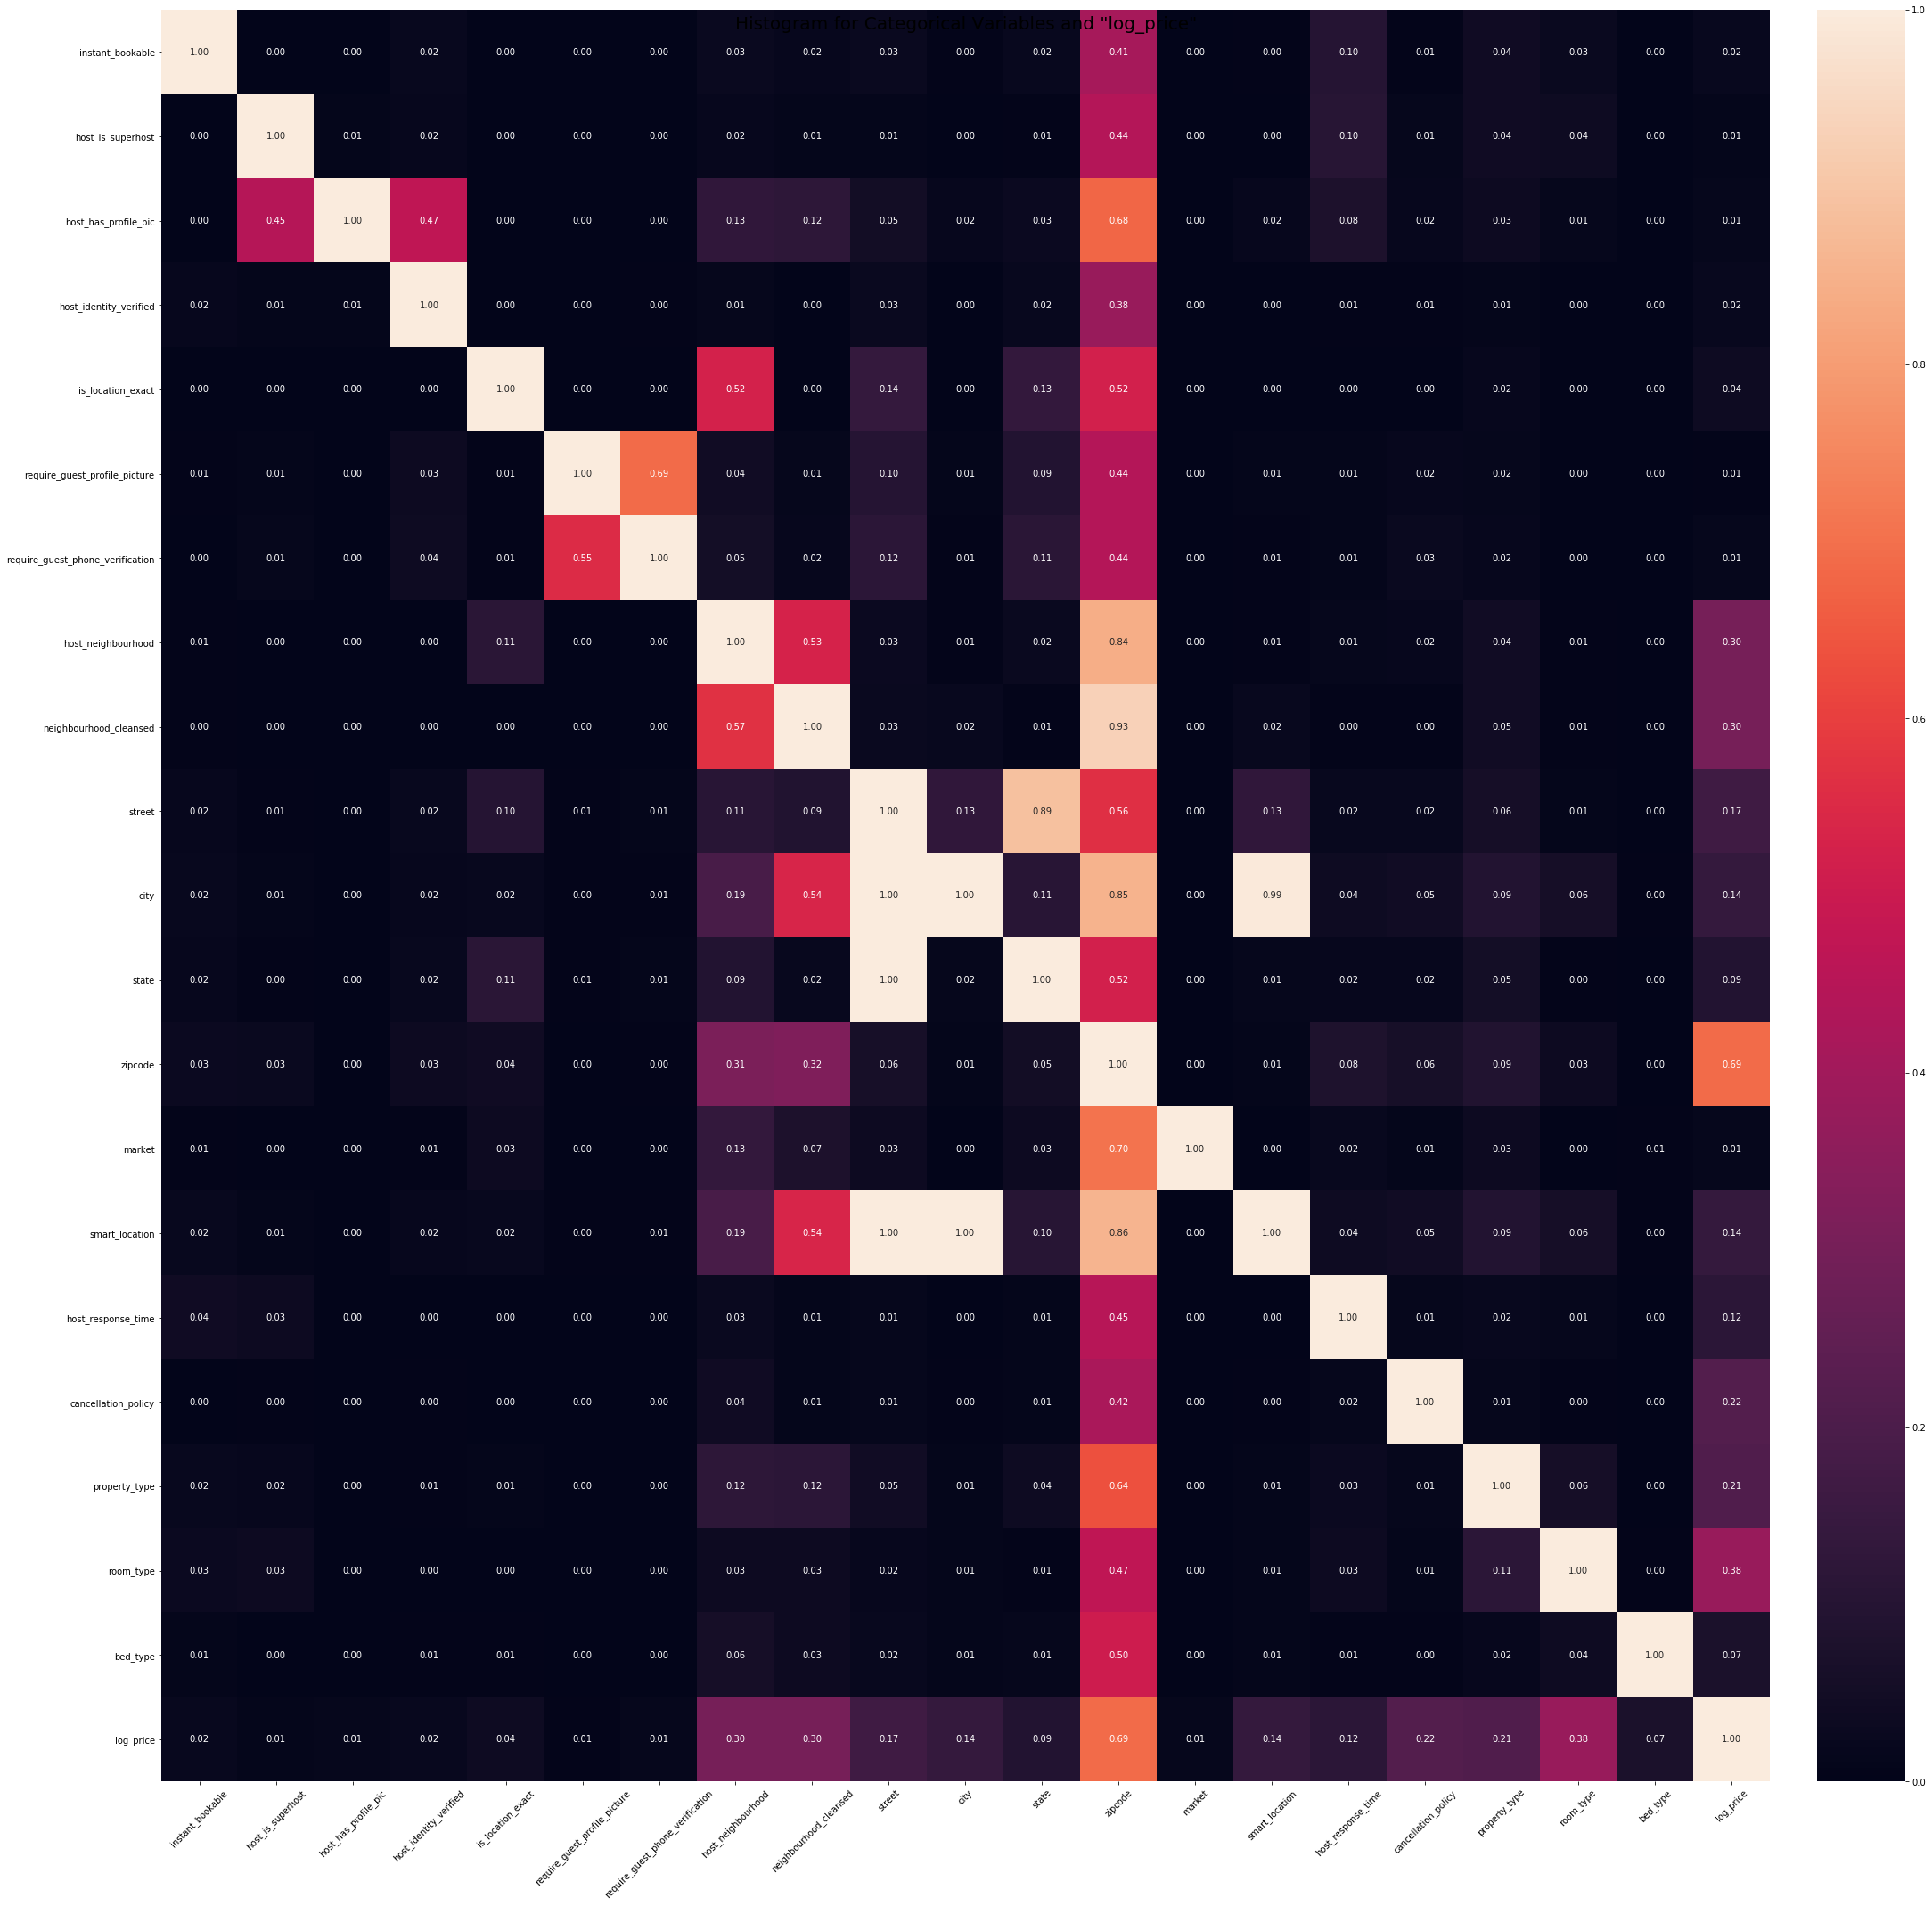

In [981]:
fig, ax = plt.subplots(figsize=(30, 30))
associations(df[cat_attribs_to_plot+["log_price"]], nominal_columns=cat_attribs_to_plot, theil_u=True, ax=ax)
plt.xticks(rotation=45)
plt.suptitle('Histogram for Categorical Variables and "log_price"')
plt.savefig("../imgs/correlation_heatmap_after.png")

The result verifies our belief that the spatial variables as a group and the verification variables as a group are highly correlated, respectively, as expectend. Two things are perhaps surprising here. 

First, the zipcode varaible is strongly correlated with vertually all other variables here. Unfortunately we won't use it since it has way too many different categories. The good news is that the correlation heatmap points neighbourhood_cleansed as a good alternative due to its strong level of correlation with zip code.

Second, the log_price variable is relatively correlated with roome type.

### Spatial variables 

In [982]:
locations_variables = ["host_neighbourhood", "neighbourhood_cleansed", "street", "city", "state", "zipcode", "smart_location", "market"]

for col in locations_variables:
    print(f"{col} has {df[col].nunique()} unique values")

host_neighbourhood has 81 unique values
neighbourhood_cleansed has 22 unique values
street has 103 unique values
city has 34 unique values
state has 52 unique values
zipcode has 7207 unique values
smart_location has 35 unique values
market has 4 unique values


In [983]:
locations_variables.remove("neighbourhood_cleansed")
df, cat_attribs = helpers.drop_attribs(df, cat_attribs, locations_variables)
cat_attribs_to_plot = [i for i in cat_attribs if i != "host_verifications"]

### Host verification 

Some customers would prefer verified hosts, which could result in product differentiation (different house prices).

In [984]:
all_verification_methods = [item for item in df["host_verifications"].tolist() if item]
all_verification_methods = set(reduce(lambda x, y: x+y, all_verification_methods))
all_verification_methods

{'email',
 'facebook',
 'google',
 'government_id',
 'identity_manual',
 'jumio',
 'kba',
 'manual_offline',
 'manual_online',
 'offline_government_id',
 'phone',
 'reviews',
 'selfie',
 'sent_id',
 'sesame',
 'sesame_offline',
 'weibo',
 'work_email',
 'zhima_selfie'}

### Feature Engineering
It appears that email, facebook, government_id, and phone would be reliable identification methods, so we construct a boolean feature that would be true if a host has any of those 

In [985]:
good_verification_methods = ["email", "facebook", "government_id", "phone"]

def is_nicely_verified(host_verifications):
    if not host_verifications:
        return "f"
    
    for ele in good_verification_methods:
        if ele in host_verifications:
            return "t"
    
    return "f"

In [986]:
df["nicely_verified"] = df["host_verifications"].apply(lambda x: is_nicely_verified(x))
df["nicely_verified"].value_counts()

t    20456
f      220
Name: nicely_verified, dtype: int64

Only about 2% of the hosts are not "nicely verified." However, we would still use it as a categorical variable
because the low percentage is real instead of missing data (referring back to the missing data examination code above). 

In [987]:
cat_attribs.append("nicely_verified")
df, cat_attribs = helpers.drop_attribs(df, cat_attribs, ["host_verifications"])
cat_attribs_to_plot = [i for i in cat_attribs if i != "host_verifications"]

Inspect the correlation heatmap again.

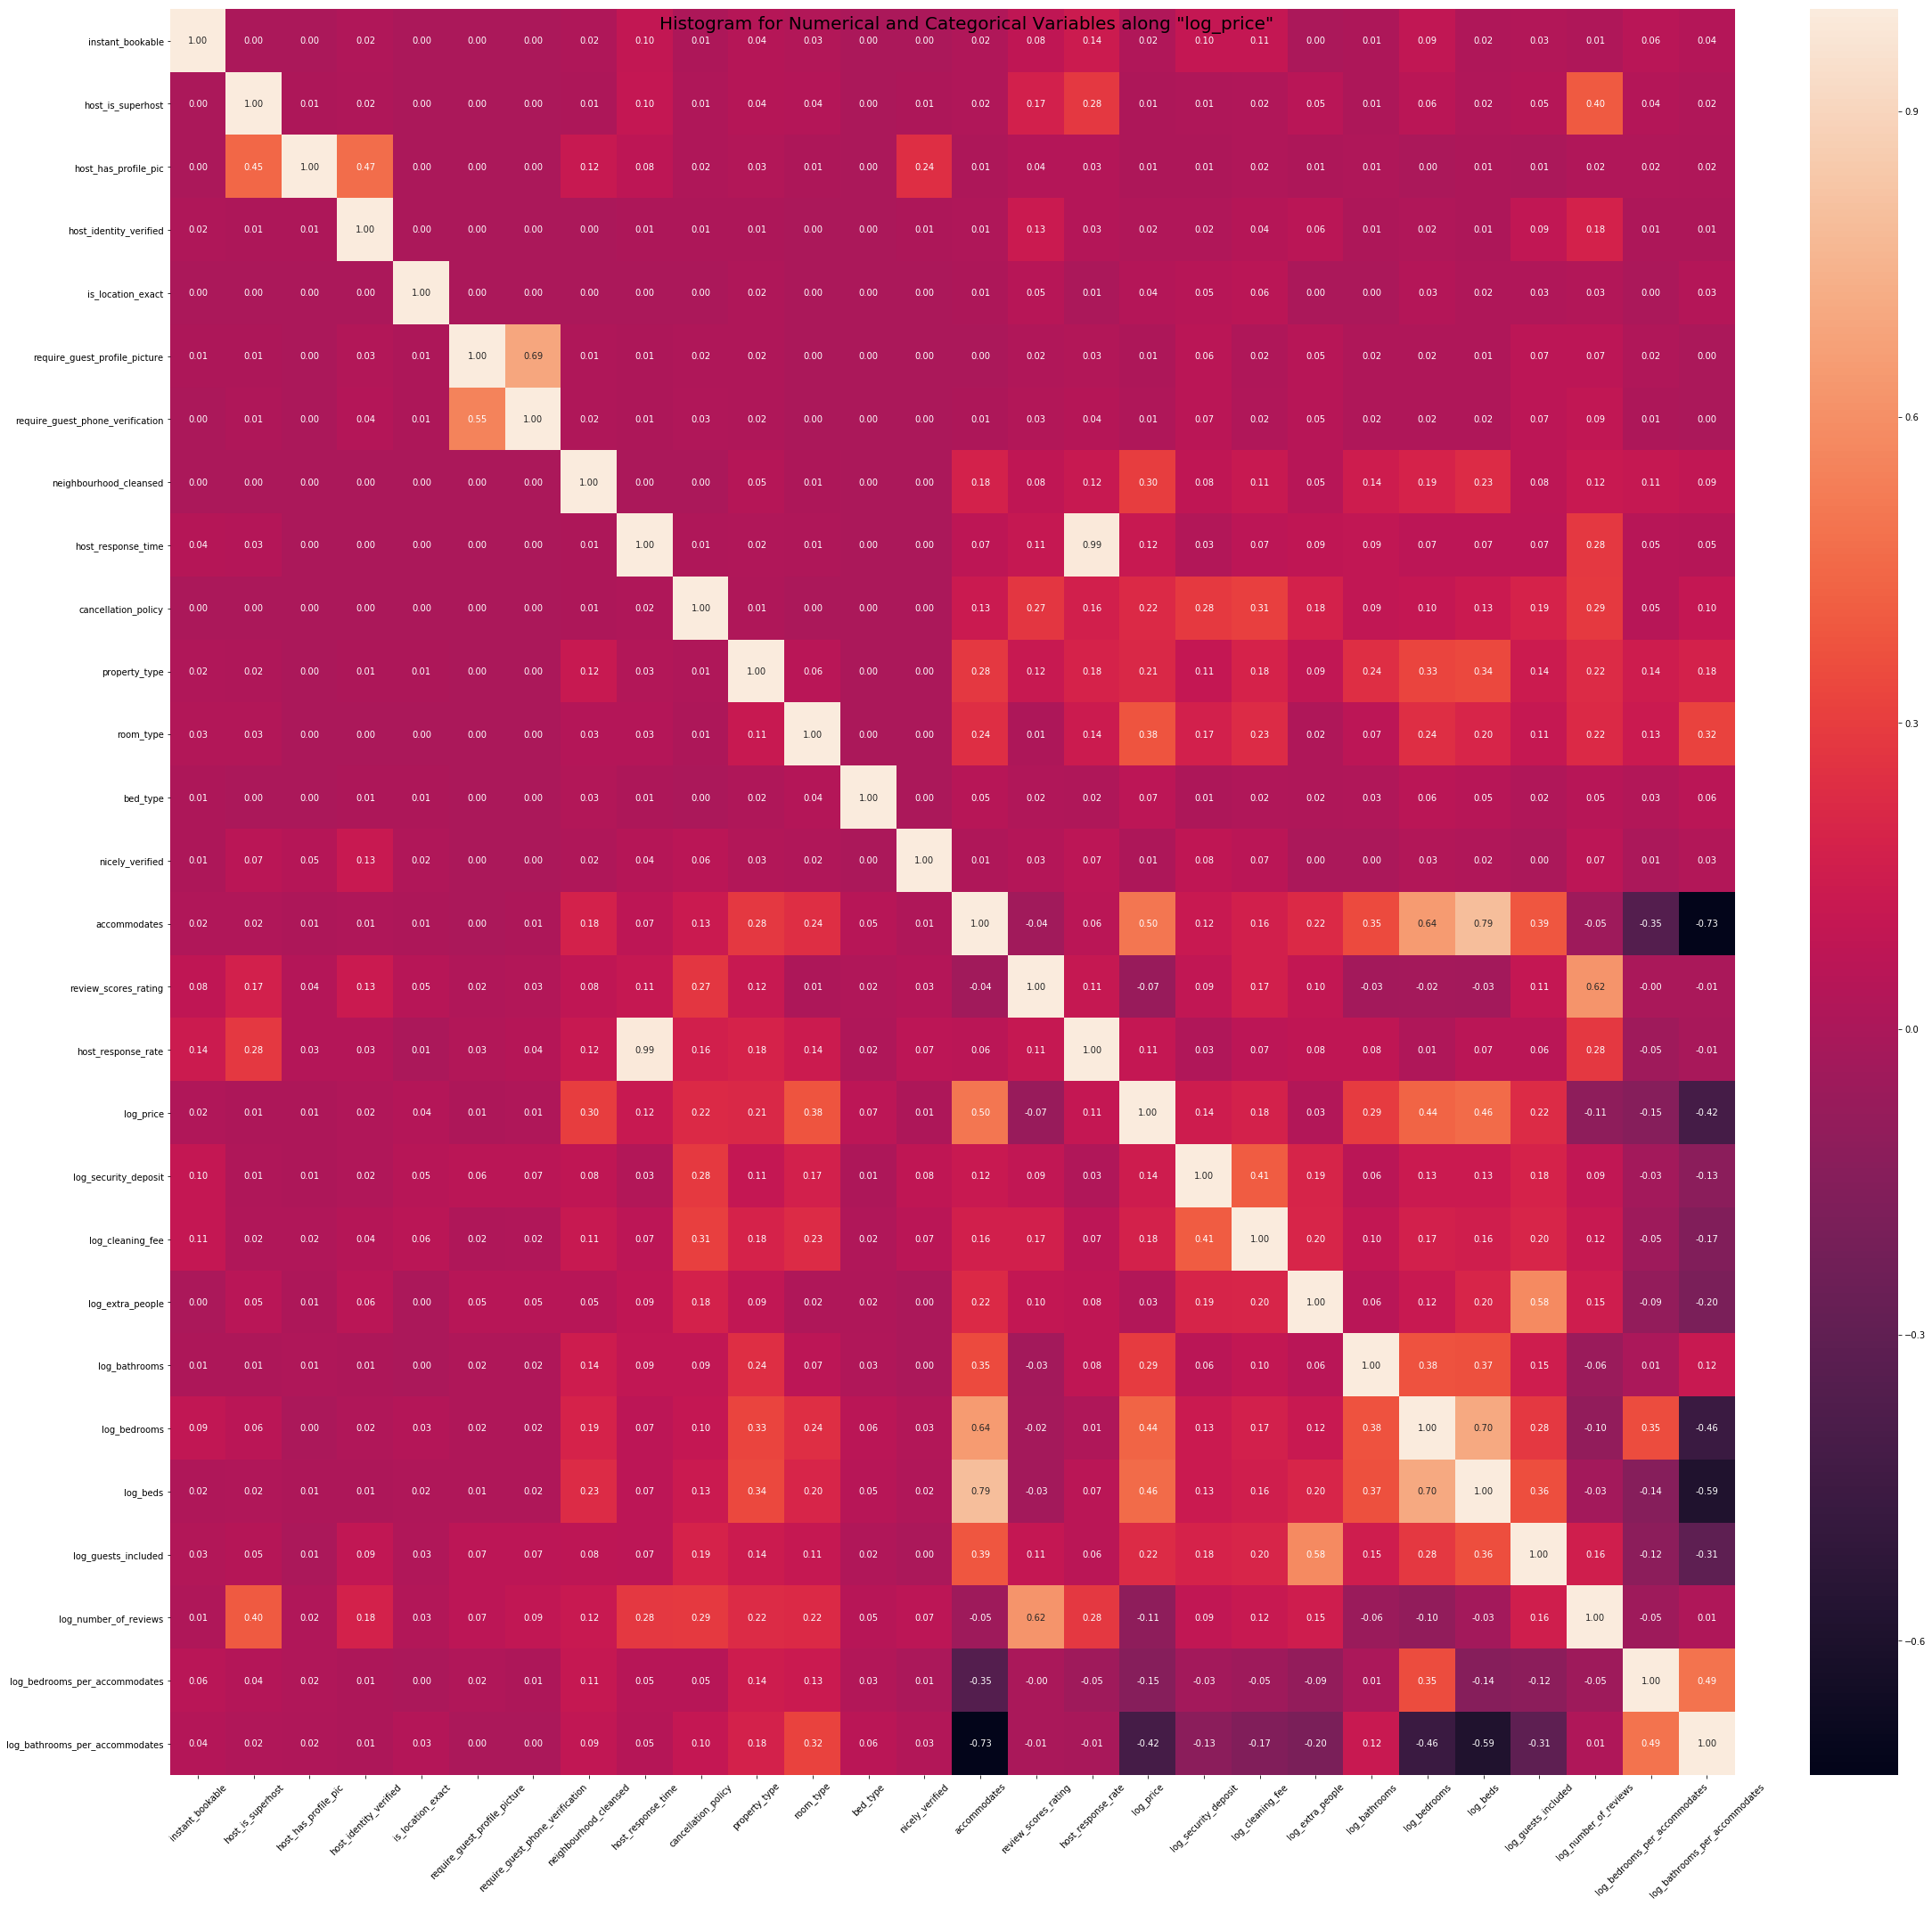

In [988]:
fig, ax = plt.subplots(figsize=(30, 30))
associations(df[cat_attribs_to_plot+num_attribs], nominal_columns=cat_attribs_to_plot, theil_u=True, ax=ax)
plt.xticks(rotation=45)
plt.suptitle('Histogram for Numerical and Categorical Variables along "log_price"')
plt.savefig("../imgs/correlation_heatmap_final.png")

Check the saved transformed correlation_heatmap [here](../imgs/correlation_heatmap_after.png).

It's interesting that "accommodates" is relatively positively correlated with most variables while "log_bedroom_per_accommdates" and "log_bathroom_per_accommdates" are relatively negatively correlated with most variables. 
I find it somewhat hard to come up with explanations.

Otherwise, the plots look quite good for us to move forward.

In [989]:
## Save the cleaned dataframe

df.to_pickle("../data/df.pkl")

pickle.dump(num_attribs, open('../data/num_attribs.pkl', 'wb'))   
pickle.dump(cat_attribs, open('../data/cat_attribs.pkl', 'wb'))

# Concluding EDA

Now we conclude the data cleaning and exploration steps. Please move forward to the other scripts ordered in [README.md](https://github.com/Zackhardtoname/airbnb_dataset_challenge/blob/master/README.md).